In [3]:
import os
import pandas as pd

dataset_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app','static','uploads', 'dataset.csv'))


In [ ]:
df_comments = pd.read_csv(dataset_path)
df_comments.tail()

In [ ]:
df_comments['label'].value_counts()

## Lakukan Preprocessing

In [6]:
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

stemmer = StemmerFactory().create_stemmer()
stopword_factory = StopWordRemoverFactory()
combined_stopwords = set(stopword_factory.get_stop_words()).union(set(stopwords.words('english')))

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in combined_stopwords]
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)


df_comments['preprocess'] = df_comments['comment'].apply(preprocess_text)

## POLARISASI KATA

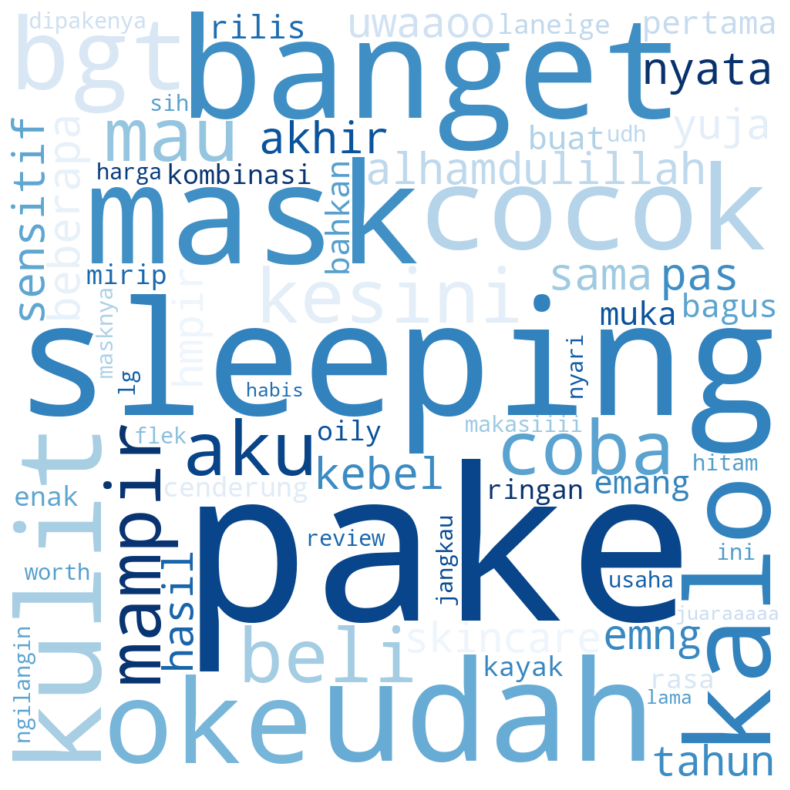

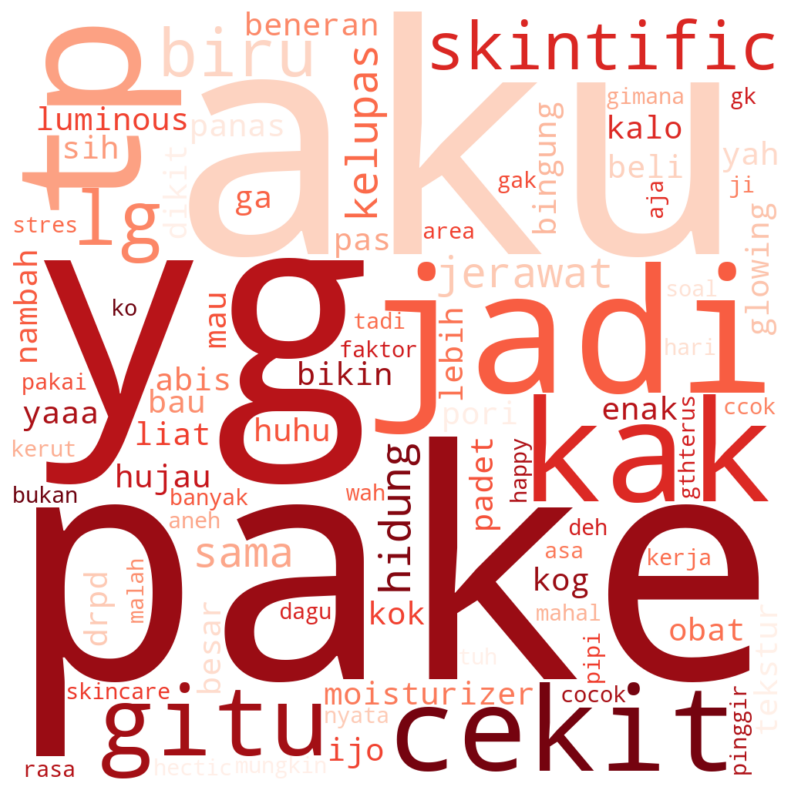

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# polarisasi positif
dataset_negatif = df_comments[df_comments['label'] == 'positif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
# plt.show()

# polarisasi negatif
dataset_negatif = df_comments[df_comments['label'] == 'negatif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
# plt.show()

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_comments['preprocess'], df_comments['label'], test_size=0.2, stratify=df_comments['label'], random_state=0)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

corpus = [
    'pusing satu kali',
    'pusing dua kali',
    'pusing tiga kali',
    'pusing lagi',
]

X = vectorizer.fit_transform(corpus)
# X.toarray()
X.todense()
# vectorizer.get_feature_names_out()

print(X)

df = pd.DataFrame(X.toarray().T, index=vectorizer.get_feature_names_out(), columns=[f'D{i+1}' for i in range(len(corpus))])
df

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (4, 6)>
  Coords	Values
  (0, 3)	0.40264193560603856
  (0, 4)	0.7715790094657221
  (0, 1)	0.4924888870251974
  (1, 3)	0.40264193560603856
  (1, 1)	0.4924888870251974
  (1, 0)	0.7715790094657221
  (2, 3)	0.40264193560603856
  (2, 1)	0.4924888870251974
  (2, 5)	0.7715790094657221
  (3, 3)	0.46263733109032296
  (3, 2)	0.8865476297873808


,D1,D2,D3,D4
dua,0.000000,0.771579,0.000000,0.000000
kali,0.492489,0.492489,0.492489,0.000000
lagi,0.000000,0.000000,0.000000,0.886548
pusing,0.402642,0.402642,0.402642,0.462637
satu,0.771579,0.000000,0.000000,0.000000
tiga,0.000000,0.000000,0.771579,0.000000


In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Corpus data
corpus = [
    'pusing satu kali',
    'pusing dua kali',
    'pusing tiga kali',
    'pusing lagi',
]

# Initialize vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform corpus to get TF-IDF matrix
X = vectorizer.fit_transform(corpus)

# Get feature names (terms)
terms = vectorizer.get_feature_names_out()

# Get IDF values
idf_values = vectorizer.idf_

# Create DataFrame for TF-IDF values
tfidf_df = pd.DataFrame(X.toarray().T, index=terms, columns=[f'D{i+1}' for i in range(len(corpus))])

# Create DataFrame for IDF values
idf_df = pd.DataFrame(idf_values, index=terms, columns=["IDF"])

# Calculate TF manually
def compute_tf(doc):
    # Tokenize and count term occurrences
    words = doc.split()
    count = Counter(words)
    total_terms = len(words)
    # Compute TF
    tf = {term: count[term] / total_terms for term in count}
    return tf

# Compute TF for each document
tf_dicts = [compute_tf(doc) for doc in corpus]
tf_df = pd.DataFrame(tf_dicts, index=[f'D{i+1}' for i in range(len(corpus))]).T

# Fill NaN values with 0
tf_df = tf_df.fillna(0)
idf_df = idf_df.fillna(0)
tfidf_df = tfidf_df.fillna(0)

# Display DataFrames
print("Term Frequency (TF):")
print(tf_df)
print("\nInverse Document Frequency (IDF):")
print(idf_df)
print("\nTF-IDF Matrix:")
print(tfidf_df)


Term Frequency (TF):
              D1        D2        D3   D4
pusing  0.333333  0.333333  0.333333  0.5
satu    0.333333  0.000000  0.000000  0.0
kali    0.333333  0.333333  0.333333  0.0
dua     0.000000  0.333333  0.000000  0.0
tiga    0.000000  0.000000  0.333333  0.0
lagi    0.000000  0.000000  0.000000  0.5

Inverse Document Frequency (IDF):
             IDF
dua     1.916291
kali    1.223144
lagi    1.916291
pusing  1.000000
satu    1.916291
tiga    1.916291

TF-IDF Matrix:
              D1        D2        D3        D4
dua     0.000000  0.771579  0.000000  0.000000
kali    0.492489  0.492489  0.492489  0.000000
lagi    0.000000  0.000000  0.000000  0.886548
pusing  0.402642  0.402642  0.402642  0.462637
satu    0.771579  0.000000  0.000000  0.000000
tiga    0.000000  0.000000  0.771579  0.000000


In [11]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# print(X_train)
# print(X_test)

In [12]:
from sklearn.svm import SVC

model = SVC(random_state=0, kernel='rbf')

model.fit(X_train, y_train)
predict = model.predict(X_test)
print(predict)


['positif' 'negatif']


In [13]:
from sklearn.metrics import classification_report

y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00       1.0
     positif       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# f1-score
print('F1-Score : ', f1_score(y_test, predict, pos_label='positif'))
# Accuracy
print('Accuracy : ', accuracy_score(y_test, predict))
# precision
print('Precision : ', precision_score(y_test, predict, pos_label='positif'))
# recall
print('Recall : ', recall_score(y_test, predict, pos_label='positif'))


# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
tn, fp, fn, tp


F1-Score :  0.0
Accuracy :  0.0
Precision :  0.0
Recall :  0.0


(np.int64(0), np.int64(1), np.int64(1), np.int64(0))

In [15]:
def cleansing(data):
    # lower text
    data = data.lower()
    # remove punctuation
    remove = string.punctuation
    translator = str.maketrans (remove, ' '*len(remove))
    data = data.translate (translator)
    # remove ASCII dan unicode
    data = data.encode('ascii', 'ignore').decode('utf-8')
    data = re.sub(r'[^\x00-\x7f]',r'', data)
    # remove newline
    data = data.replace('\n', '')

    return data

def preprocess_data(data):
    # cleansing data
    data = cleansing(data)
    # remove stopwords
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    data = stopword.remove(data)
    # stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    data = stemmer.stem(data)
    # count vectorizer
    data = vectorizer.transform([data])
    return data

In [16]:
model.predict(preprocess_data('jelek banget kulit kering dan beruntusan, pakek skincare ada rasa gatal dikit'))

array(['positif'], dtype=object)